In [1]:
# imports

from functools import reduce
import itertools
import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.colors as mcolors
from barnacle import plot_factors_heatmap
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
import tensorly as tl
from tensorly.cp_tensor import CPTensor
import tlviz
from tlviz.factor_tools import factor_match_score
from tlab.cp_tensor import load_cp_tensor
import xarray as xr
from barnacle.tensors import SparseCPTensor

# ignore chained assignment warning in pandas
pd.set_option('mode.chained_assignment', None)


In [2]:
# helpful functions
    
# function to select subset of indices in cp tensor
def subset_cp_tensor(cp_tensor, subset_indices):
    '''Selects subset of cp_tensor based on provided indices
    
    Parameters
    ----------
    cp_tensor : tensorly.CPTensor
        CPTensor object with (weights, factors).
    subset_indices : dict(int: index-like)
        Dictionary with mode as key and value an integer index of 
        the positions to be downselected from `cp_tensor`.
        Example: {1: [0, 1, 3, 4, 5, 8]}
        
    Returns
    -------
    subset_cp : tensorly.CPTensor
        Subset CPTensor.
    '''
    weights, factors = cp_tensor
    new_factors = factors.copy()
    for mode, index in subset_indices.items():
        new_factors[mode] = factors[mode][index]
    return(CPTensor((weights, new_factors)))


# functions to build continuous colormap
# source: https://towardsdatascience.com/beautiful-custom-colormaps-with-matplotlib-5bab3d1f0e72

def hex_to_rgb(value):
    '''
    Converts hex to rgb colours
    value: string of 6 characters representing a hex colour.
    Returns: list length 3 of RGB values'''
    value = value.strip("#") # removes hash symbol if present
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16) for i in range(0, lv, lv // 3))


def rgb_to_dec(value):
    '''
    Converts rgb to decimal colours (i.e. divides each value by 256)
    value: list (length 3) of RGB values
    Returns: list (length 3) of decimal values'''
    return [v/256 for v in value]

def get_continuous_cmap(hex_list, float_list=None):
    ''' creates and returns a color map that can be used in heat map figures.
        If float_list is not provided, colour map graduates linearly between each color in hex_list.
        If float_list is provided, each color in hex_list is mapped to the respective location in float_list. 
        
        Parameters
        ----------
        hex_list: list of hex code strings
        float_list: list of floats between 0 and 1, same length as hex_list. Must start with 0 and end with 1.
        
        Returns
        ----------
        colour map'''
    rgb_list = [rgb_to_dec(hex_to_rgb(i)) for i in hex_list]
    if float_list:
        pass
    else:
        float_list = list(np.linspace(0,1,len(rgb_list)))
        
    cdict = dict()
    for num, col in enumerate(['red', 'green', 'blue']):
        col_list = [[float_list[i], rgb_list[i][num], rgb_list[i][num]] for i in range(len(float_list))]
        cdict[col] = col_list
    cmp = mcolors.LinearSegmentedColormap('my_cmp', segmentdata=cdict, N=256)
    return cmp


In [3]:
# set aesthetic parameters

line_color = '#0F0A0A'    # dark
# line_color = '#E5E4E2'    # light

neutral_color = '#E0E0E0'

# thursday
accent_colors = ['#9B5DE5', '#FFAC69', '#00C9AE', '#FD3F92', '#0F0A0A', 
                 '#959AB1', '#FFDB66', '#63B9FF','#FFB1CA', '#4F1DD7']

style = {'axes.edgecolor': line_color,
         'axes.labelcolor': line_color,
         'text.color': line_color,
         'xtick.color': line_color,
         'ytick.color': line_color,
         'font.family': 'Helvetica',
         'font.Helvetica': ['Helvetica']}

palette = sns.color_palette(accent_colors)

sns.set_context('talk', rc={'lines.linewidth': 2})
sns.set_palette(palette)
# sns.set_palette('tab20')
sns.set_style('ticks', style)

plt.rcParams['legend.frameon'] = False
plt.rcParams['axes.spines.left'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.bottom'] = False
plt.rcParams['axes.facecolor'] = 'none'
plt.rcParams['figure.facecolor'] = 'none'
plt.rcParams['patch.linewidth'] = 0
plt.rcParams['patch.edgecolor'] = 'none'
plt.rcParams['savefig.dpi'] = 300

div_hexes = ['#7222D3', neutral_color, '#FF780A']
div_cmap = get_continuous_cmap(div_hexes)


# collect and organize data

In [4]:
# data structures

# parameters
ref_boots = np.arange(100)
comp_boots= np.arange(10)
replicates = ['A', 'B', 'C']
datapath = Path('../models/')
outdir = Path('../figures/v2-batch-t=0.01/')

# set data to analyze
ranks = {
    'pro': {
        'ref': 20, 
        'comp': [1, 4, 8, 12, 16, 20]
    }, 
    'syn': {
        'ref': 15, 
        'comp': [1, 3, 6, 9, 12, 15]
    }
}
lambdas = {
    'pro': {
        'ref': 16., 
#         'comp': [0., .1, 1., 10., 16., 100.]
        'comp': [1., 2., 4., 8., 16., 32., 64.]
    }, 
    'syn': {
        'ref': 16., 
#         'comp': [0., .1, 1., 10., 16., 100.]
        'comp': [1., 2., 4., 8., 16., 32., 64.]
    }
}

# set best representatives (based on analysis in component-robustness.ipynb)
best_reps = {
    'pro': {
        'rank': 20, 
        'lambda': 16.0, 
        'boot': 31, 
        'rep': 'A'
    }, 
    'syn': {
        'rank': 15, 
        'lambda': 16.0, 
        'boot': 41, 
        'rep': 'A'
    }
}

# set up data structure to store sample name data
samplenames = {
    'pro' : {
        rep: [] for rep in replicates
    },
    'syn' : {
        rep: [] for rep in replicates
    }
}

# set up data structures to store cp tensors
cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}
aligned_cps = {
    'pro' : {
        rep: {} for rep in replicates
    },
    'syn' : {
        rep: {} for rep in replicates
    }
}


In [5]:
# fetch samplename labels for each shuffled replicate set

# collect sample names of each bootstrap/replicate pair
for cyano in ['pro', 'syn']: 
    for rep in replicates:
        for boot in ref_boots:
            filepath = datapath / '{}/bootstrap{}/replicate{}/shuffled_replicate_{}.nc'.format(
                cyano, boot, rep, rep
            )
            ds = xr.open_dataset(filepath)
            samplenames[cyano][rep].append(ds.samplename.data)

    # compile set of samplenames common to all bootstrap / replicate splits
    samplenames[cyano]['common'] = reduce(
        np.intersect1d, 
        itertools.chain.from_iterable([samplenames[cyano][r] for r in replicates])
    )

# import one shuffled tensor dataset for reference
pro_ds = xr.open_dataset(datapath / 'pro/bootstrap0/dataset_bootstrap_0.nc')
syn_ds = xr.open_dataset(datapath / 'syn/bootstrap0/dataset_bootstrap_0.nc')

syn_ds


<xarray.Dataset>
Dimensions:     (ortholog: 6161, clade: 6, sample: 222)
Coordinates:
  * ortholog    (ortholog) int64 60000001 60000002 ... 60040219 60040245
  * clade       (clade) object '5.1A-I' '5.1A-II' ... '5.1B-VII' 'CDR2'
  * sample      (sample) object 'G1.SURF.NS.S02C1.15m.A' ... 'G3.UW.NS.UW40_2...
Data variables:
    readcount   (ortholog, clade, sample) float64 ...
    residual    (ortholog, clade, sample) float64 ...
    replicate   (sample) object ...
    samplename  (sample) object ...
    annotation  (ortholog) object ...
Attributes:
    shuffle_seed:  1336149668

In [6]:
# import all fitted models, and subset them to just the common samplenames

for cyano in ['pro', 'syn']:
    for rep in replicates:
        for rank in ranks[cyano]['comp']:
            # initialize dict of cp tensors for each rank
            cps[cyano][rep][rank] = {}
            aligned_cps[cyano][rep][rank] = {}
            for lamb in lambdas[cyano]['comp']:
                # initialize list of cp tensors for each lambda
                cps[cyano][rep][rank][lamb] = []
                aligned_cps[cyano][rep][rank][lamb] = []
                for boot in ref_boots:
                    if boot not in comp_boots and not (rank == ranks[cyano]['ref'] and lamb == lambdas[cyano]['ref']):
                        continue    # only pull in higher bootstrap models corresponding to reference model
                    # put together data path
                    path_cp = '{}/bootstrap{}/replicate{}/rank{}/lambda{}/fitted_model.h5'.format(
                        cyano, boot, rep, rank, lamb
                    )
                    # store normalized cp tensor to cps
                    cp = tl.cp_normalize(load_cp_tensor(datapath / path_cp))
                    cps[cyano][rep][rank][lamb].append(cp)
                    # pull out common samplenames and store in aligned_cps
                    idx = np.where(np.isin(samplenames[cyano][rep][boot], samplenames[cyano]['common']))[0]
                    aligned_cps[cyano][rep][rank][lamb].append(
                        subset_cp_tensor(cp, {2: idx})
                    )
            
aligned_cps['syn']['A'][15][16.][9]


(weights, factors) : rank-15 CPTensor of shape (6161, 6, 55)

# compare aligned components
- choose best representative reference cp tensor
    - reference rank
    - choose based on best overall mean FMS agains all other cp tensors
- sort reference tensor components in order of variance explained
- align all other tensors to sorted reference tensor (using None-type tensors to fill gaps)
- calculate FMS between each pair of aligned components (comparison vs. reference)


In [7]:
# set best representative reference cp tensor

In [8]:
# # find best representative reference cp tensor for each genus

# results = []
# for cyano, ref_rep, ref_boot in list(itertools.product(['pro', 'syn'], replicates, bootstraps)):
#     ref_rank = ranks[cyano]['ref']
#     ref_lamb = lambdas[cyano]['ref']
#     reference_cp = aligned_cps[cyano][ref_rep][ref_rank][ref_lamb][ref_boot]
#     for comp_rep, comp_rank, comp_lamb, comp_boot in list(itertools.product(
#         replicates, ranks[cyano]['comp'], lambdas[cyano]['comp'], bootstraps
#     )):
#         # no point in comparing to self
#         if ref_rep == comp_rep and ref_rank == comp_rank and ref_lamb == comp_lamb and ref_boot == comp_boot:
#             continue
#         comparison_cp = aligned_cps[cyano][comp_rep][comp_rank][comp_lamb][comp_boot]
#         fms = factor_match_score(
#             reference_cp, 
#             comparison_cp, 
#             consider_weights=False
#         )
#         results.append({
#             'genus': cyano, 
#             'reference_rank': ref_rank, 
#             'reference_lambda': ref_lamb, 
#             'reference_bootstrap': ref_boot, 
#             'reference_replicate': ref_rep, 
#             'comparison_rank': comp_rank, 
#             'comparison_lambda': comp_lamb, 
#             'comparison_bootstrap': comp_boot, 
#             'comparison_replicate': comp_rep, 
#             'fms': fms, 
#         })
        
# fms_df = pd.DataFrame(results)

# # summarize overall mean fms
# best_rep_df = fms_df.groupby([
#     'genus', 
# #     'comparison_rank', 
#     'reference_rank', 
#     'reference_lambda', 
#     'reference_bootstrap', 
#     'reference_replicate'
# ]).agg(
#     mean_fms=('fms', 'mean'), 
#     boot_count=('fms', 'count')
# ).reset_index()
# # find the top mean for each comparison rank
# # best_rep_df = best_rep_df.sort_values(['genus', 'mean_fms'], ascending=False)
# best_rep_df = best_rep_df.iloc[best_rep_df.groupby([
#     'genus', 
# #     'comparison_rank'
# ]).mean_fms.idxmax().values, :]

# best_rep_df


In [9]:
# collect aligned component comparison data

results = []
for cyano in ['pro', 'syn']:
    # pull out reference cp
    ref_rep = best_reps[cyano]['rep']
    ref_rank = best_reps[cyano]['rank']
    ref_lamb = best_reps[cyano]['lambda']
    ref_boot = best_reps[cyano]['boot']
    # sort reference cp factors in order of explained variance
    reference_cp = tlviz.factor_tools.permute_cp_tensor(
        aligned_cps[cyano][ref_rep][ref_rank][ref_lamb][ref_boot], 
        consider_weights=True
    ) 
    aligned_cps[cyano][ref_rep][ref_rank][ref_lamb][ref_boot] = reference_cp
    # separate out components
    ref_components = SparseCPTensor(reference_cp).get_components()
    # iterate through all cp tensors to be compared
    for comp_rep, comp_rank, comp_lamb, comp_boot in list(itertools.product(
            replicates, ranks[cyano]['comp'], lambdas[cyano]['comp'], ref_boots
        )):
        if comp_boot not in comp_boots and not (comp_rank == ranks[cyano]['ref'] and comp_lamb == lambdas[cyano]['ref']):
            continue    # only look at bootstraps beyond comparison bootstraps if they match reference params
        elif ref_rep == comp_rep and ref_rank == comp_rank and ref_lamb == comp_lamb and ref_boot == comp_boot:
            continue    # no point in comparing to self
        # re-align comparison cp to the reference cp
        comparison_cp = tlviz.factor_tools.permute_cp_tensor(
            aligned_cps[cyano][comp_rep][comp_rank][comp_lamb][comp_boot], 
            reference_cp_tensor=reference_cp, 
            consider_weights=False, 
            allow_smaller_rank=True
        )
        aligned_cps[cyano][comp_rep][comp_rank][comp_lamb][comp_boot] = comparison_cp
        # compare each aligned component
        for i, comp_component in enumerate(SparseCPTensor(comparison_cp).get_components()):
            # skip the None-type components included for aligning smaller cp tensors
            if np.all(np.isnan(comp_component.factors[0])):
                continue
            # compare components
            fms = factor_match_score(
                comp_component, 
                ref_components[i], 
                consider_weights=False,
            )
            # save results
            results.append({
                'genus': cyano, 
                'reference_bootstrap': ref_boot, 
                'reference_replicate': ref_rep, 
                'reference_rank': ref_rank, 
                'reference_lambda': ref_lamb, 
                'reference_component': i, 
                'comparison_bootstrap': comp_boot, 
                'comparison_replicate': comp_rep, 
                'comparison_rank': comp_rank, 
                'comparison_lambda': comp_lamb, 
                'comparison_component': i, 
                'fms': fms 
            })
            
component_df = pd.DataFrame(results)
component_df


,genus,reference_bootstrap,reference_replicate,reference_rank,reference_lambda,reference_component,comparison_bootstrap,comparison_replicate,comparison_rank,comparison_lambda,comparison_component,fms
0,pro,31,A,20,16.0,0,0,A,1,1.0,0,0.143725
1,pro,31,A,20,16.0,0,1,A,1,1.0,0,0.454834
2,pro,31,A,20,16.0,16,2,A,1,1.0,16,0.591703
3,pro,31,A,20,16.0,6,3,A,1,1.0,6,0.524087
4,pro,31,A,20,16.0,6,4,A,1,1.0,6,0.540892
...,...,...,...,...,...,...,...,...,...,...,...,...
31880,syn,41,A,15,16.0,10,9,C,15,64.0,10,0.000000
31881,syn,41,A,15,16.0,11,9,C,15,64.0,11,0.561877
31882,syn,41,A,15,16.0,12,9,C,15,64.0,12,0.000000
31883,syn,41,A,15,16.0,13,9,C,15,64.0,13,0.000000


# plot component robustness

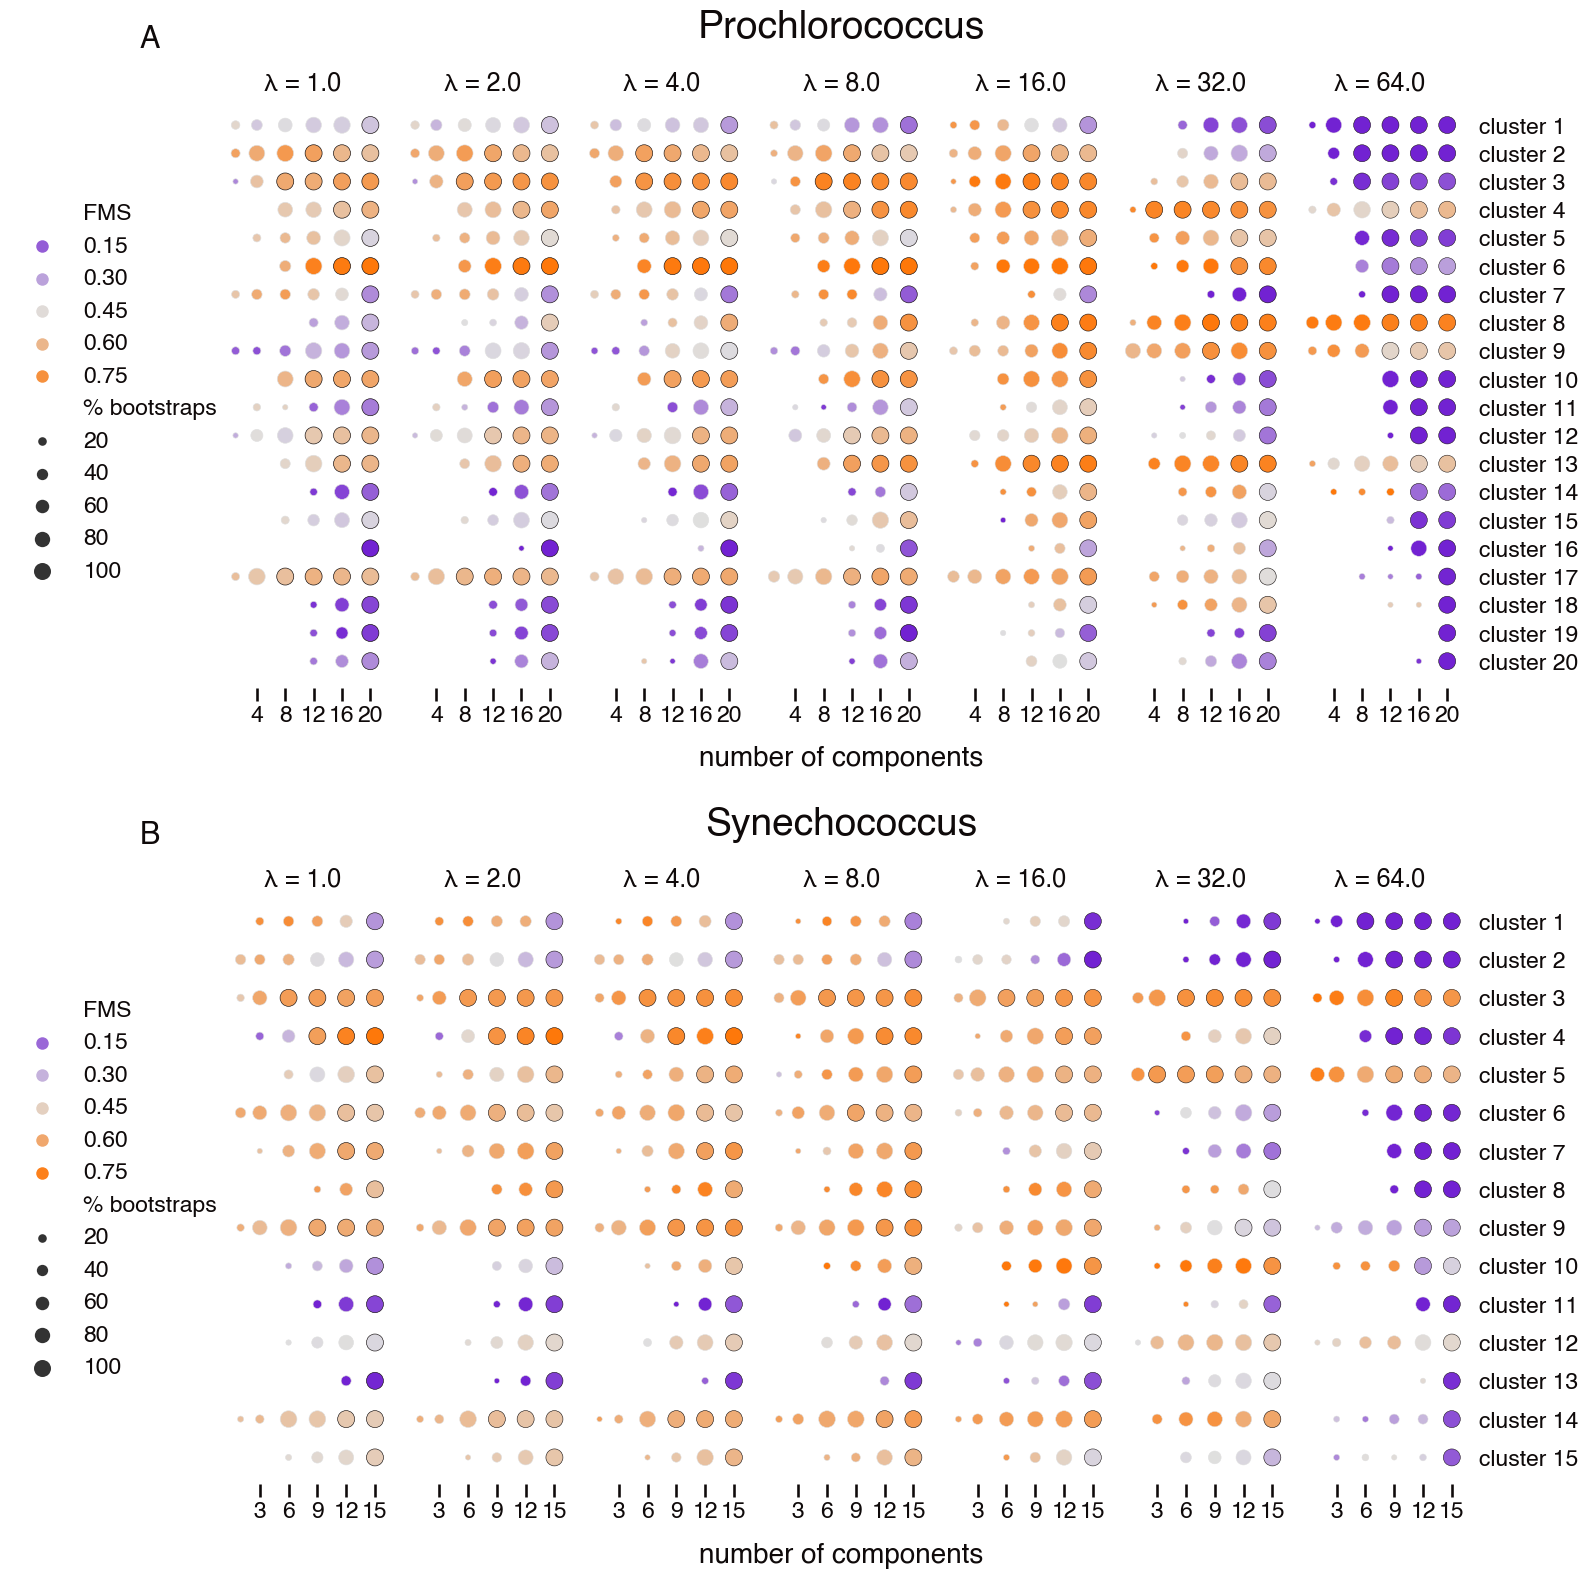

In [11]:
# component robustness to sparsity

# make multiple plots
fig, axes = plt.subplots(
    2, len(lambdas[cyano]['comp']), figsize=(16, 18), sharey='row', gridspec_kw={'wspace': 0.1, 'hspace': 0.35}
)
marker_palette = {True: line_color, False: neutral_color}

# iterate through cyanobacteria
for row, cyano in enumerate(['pro', 'syn']):
    
    # set up component robustness dataframe
    df = component_df[component_df['genus'] == cyano]
    df = df.groupby(['comparison_rank', 'comparison_lambda', 'reference_component']).agg(
        FMS = ('fms', 'mean'), 
        bootstrap_count = ('fms', 'count')
    ).reset_index()
    # calculate bootstrap percentage
    df['total_bootstraps'] = len(comp_boots) * 3
    df.loc[
        (df['comparison_rank'] == ranks[cyano]['ref']) & (df['comparison_lambda'] == lambdas[cyano]['ref']), 
        'total_bootstraps'
    ] = (len(ref_boots) * 3) - 1
    df['% bootstraps'] = df['bootstrap_count'] / df['total_bootstraps'] * 100
    df['all bootstraps'] = df['% bootstraps'] == 100
    # reverse component index order
    n_components = df['reference_component'].max() + 1
    df['component_index'] = n_components - df['reference_component']
    
    # iterate through the different sparsity coefficient values
    for i, lamb in enumerate(lambdas[cyano]['comp']):
        plot_df = df[df['comparison_lambda'] == lamb]
        sns.scatterplot(
            x='comparison_rank', 
            y='component_index', 
            hue='FMS', 
            size='% bootstraps', 
            sizes=(15, 150), 
            edgecolor=plot_df['all bootstraps'].map(marker_palette), 
            palette=div_cmap, 
            data=plot_df, 
            legend=(not i),
            ax=axes[row][i]
        ); 
        axes[row][i].set(xlabel=None, xlim={'pro': (-1, 22), 'syn': (-1, 16)}[cyano], 
                         xticks={'pro': [4, 8, 12, 16, 20], 'syn': [3, 6, 9, 12, 15]}[cyano], 
                         ylabel=None, title='λ = {}'.format(lamb))
        if i == 0:
            axes[row][i].tick_params(left=False, right=False, labelleft=False, labelright=False)
            # make legend
            axes[row][i].legend(loc='center right', alignment='right', bbox_to_anchor=(0.1, 0.5));
        elif i == len(lambdas[cyano]['comp']) - 1:
            # set cluster labels
            axes[row][-1].tick_params(left=False, right=False, labelleft=False, labelright=True)
            axes[row][-1].set_yticks(n_components - np.arange(n_components), 
                                     [f'cluster {i+1}' for i in np.arange(n_components)]);
        else:
            axes[row][i].tick_params(left=False, right=False, labelleft=False, labelright=False)
            
    # add annotations
    axes[row][0].annotate(
        {0: 'A', 1: 'B'}[row], xy=(-0.5, 1.1), xycoords='axes fraction', va='center', ha='left', 
        weight='bold', fontsize=22, annotation_clip=False
    )
    axes[row][3].annotate(
        {0: 'Prochlorococcus', 1: 'Synechococcus'}[row], xy=(0.5, 1.12), xycoords='axes fraction', 
        va='center', ha='center', weight='bold', style='italic', fontsize=28, annotation_clip=False
    )
    axes[row][3].annotate(
        'number of components', xy=(0.5, -0.12), xycoords='axes fraction', 
        va='center', ha='center', fontsize=20, annotation_clip=False
    )

fig.savefig(outdir / 'component-robustness-sparsity.png', bbox_inches='tight')


# Look at cross-validated component FMS values across lambda parameterizations
- All CPs have been aligned using a best reference of the same rank.


In [13]:
# calculated cross-validated component FMS score for aligned CP tensors

# begin calculation
results = []
for cyano in ['pro', 'syn']:
    rank = {'pro': 20, 'syn': 15}[cyano]
    # iterate through lambda levels
    for lamb in lambdas[cyano]['comp']:
        # iterate through bootstraps:
        for boot in comp_boots:
            # iterate through replicate pairs
            for ref_rep, comp_rep in [('A', 'B'), ('B', 'C'), ('C', 'A')]:
                reference_cp = aligned_cps[cyano][ref_rep][rank][lamb][boot]
                comparison_cp = aligned_cps[cyano][comp_rep][rank][lamb][boot]
                # pull out comparison components
                comp_components = SparseCPTensor(comparison_cp).get_components()
                # iterate through reference components
                for i, ref_component in enumerate(SparseCPTensor(reference_cp).get_components()):
                    if np.all(np.isnan(ref_component.factors[0])) or np.all(np.isnan(comp_components[i].factors[0])):
                        fms = np.nan
                        cluster_size = 0
                        neg_weights = 0
                        poz_weights = 0
                    else:
                        # compare components
                        fms = factor_match_score(
                            comp_components[i], 
                            ref_component, 
                            consider_weights=False,
                        )
                        # calculate genes per cluster
                        cluster_size = (ref_component.factors[0] != 0).sum()
                        neg_weights = (ref_component.factors[0] < 0).sum()
                        poz_weights = (ref_component.factors[0] > 0).sum()
                        # save results
                        results.append({
                            'genus': cyano, 
                            'bootstrap': boot, 
                            'rank': rank, 
                            'lambda': lamb, 
                            'component': i, 
                            'reference_replicate': ref_rep, 
                            'comparison_replicate': comp_rep, 
                            'ref_gene_cluster_size': cluster_size, 
                            'ref_neg_weights': neg_weights, 
                            'ref_poz_weights': poz_weights, 
                            'fms': fms
                        })
            
cv_comp_fms_df = pd.DataFrame(results)
cv_comp_fms_df


,genus,bootstrap,rank,lambda,component,reference_replicate,comparison_replicate,ref_gene_cluster_size,ref_neg_weights,ref_poz_weights,fms
0,pro,0,20,1.0,0,A,B,1197,159,1038,0.066581
1,pro,0,20,1.0,1,A,B,1089,439,650,0.612690
2,pro,0,20,1.0,2,A,B,1984,1718,266,0.800340
3,pro,0,20,1.0,3,A,B,518,176,342,0.668526
4,pro,0,20,1.0,4,A,B,1047,677,370,0.615962
...,...,...,...,...,...,...,...,...,...,...,...
7345,syn,9,15,64.0,10,C,A,0,0,0,0.000000
7346,syn,9,15,64.0,11,C,A,2,0,2,0.000000
7347,syn,9,15,64.0,12,C,A,0,0,0,0.000000
7348,syn,9,15,64.0,13,C,A,0,0,0,0.000000


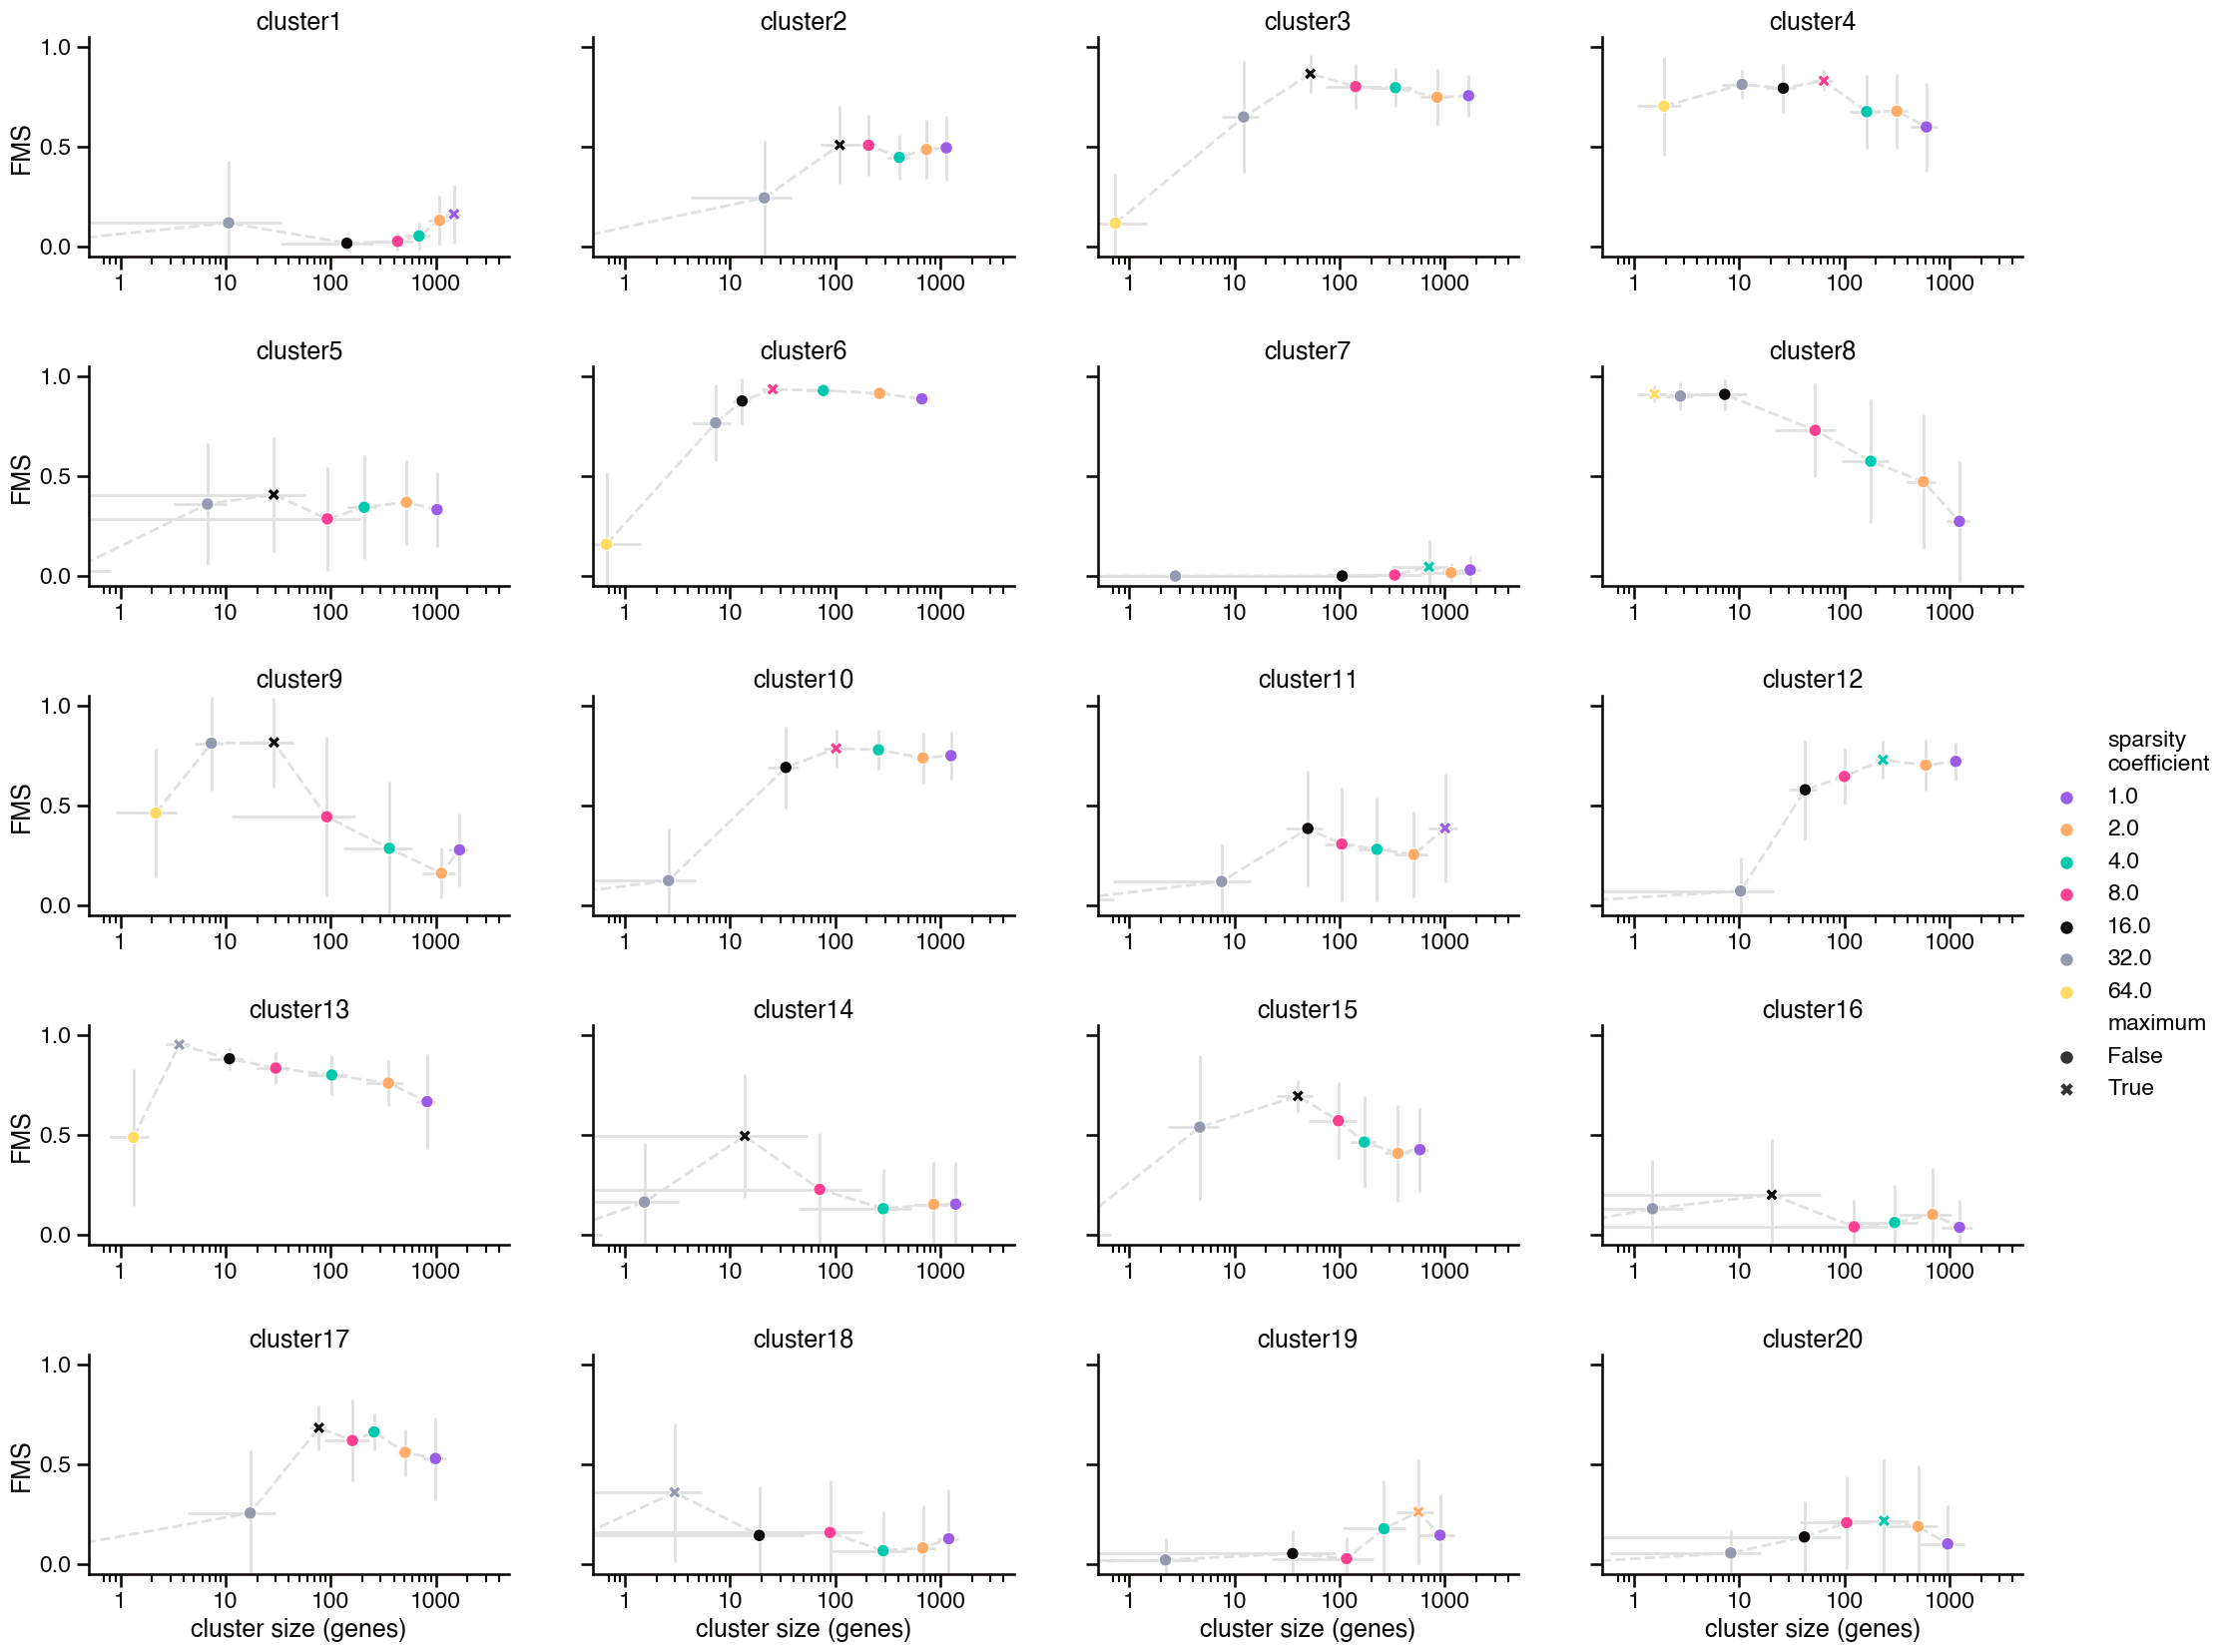

In [17]:
# plot each component FMS profile for Prochlorococcus

genus = 'pro'
rows = 5
cols = 4

# set up lambda colormap
cmap = dict(zip(lambdas[genus]['comp'], accent_colors))

# set up figure
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(25, 20), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# plot each component
for component in np.arange(20):
    row = component // cols
    col = component % cols
    axis = axes[row][col]
    plot_df = cv_comp_fms_df[cv_comp_fms_df['genus'] == genus]
    plot_df = plot_df[plot_df['component'] == component]
    plot_df = plot_df.groupby('lambda').agg(
        cluster_size=('ref_gene_cluster_size', 'mean'), 
        cluster_size_err=('ref_gene_cluster_size', 'std'), 
        fms=('fms', 'mean'), 
        fms_err=('fms', 'std'), 
    ).reset_index()
    plot_df['maximum'] = (plot_df['fms'] == plot_df['fms'].max())
    plot_df['sparsity\ncoefficient'] = ['{}'.format(l) for l in plot_df['lambda']]
    sns.lineplot(
        data=plot_df, 
        x='cluster_size', 
        y='fms', 
        errorbar=None, 
        color=neutral_color, 
        linestyle='--', 
        ax=axis, 
        legend=False
    )
    sns.scatterplot(
        data=plot_df, 
        x='cluster_size', 
        y='fms', 
        hue='sparsity\ncoefficient', 
        style='maximum', 
        zorder=3, 
        ax=axis, 
        legend=((row == 2) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 2) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # add errorbars
    axis.errorbar(
        data=plot_df, 
        x='cluster_size', 
        y='fms', 
        xerr='cluster_size_err', 
        yerr='fms_err', 
        fmt='none', 
        ecolor=neutral_color
    )
    # set labels and such
    if row == (rows - 1):
        xlabel = 'cluster size (genes)'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'FMS'
    else:
        ylabel = ''
    axis.set(
        xlim=[0.5, 5000], ylim=[-0.05, 1.05], xscale='log', xlabel=xlabel, ylabel=ylabel, 
        title='cluster{}'.format(component+1)
    )
    axis.set_xticks([1, 10, 100, 1000])
    axis.set_xticks([.7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
                     200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000], minor=True)
    formatter = mpl.ticker.ScalarFormatter()
    formatter.set_scientific(False)
    axis.xaxis.set_major_formatter(formatter)

# save figure
fig.savefig(outdir / '{}_cluster_fms_v_size.png'.format(genus), bbox_inches='tight')
    

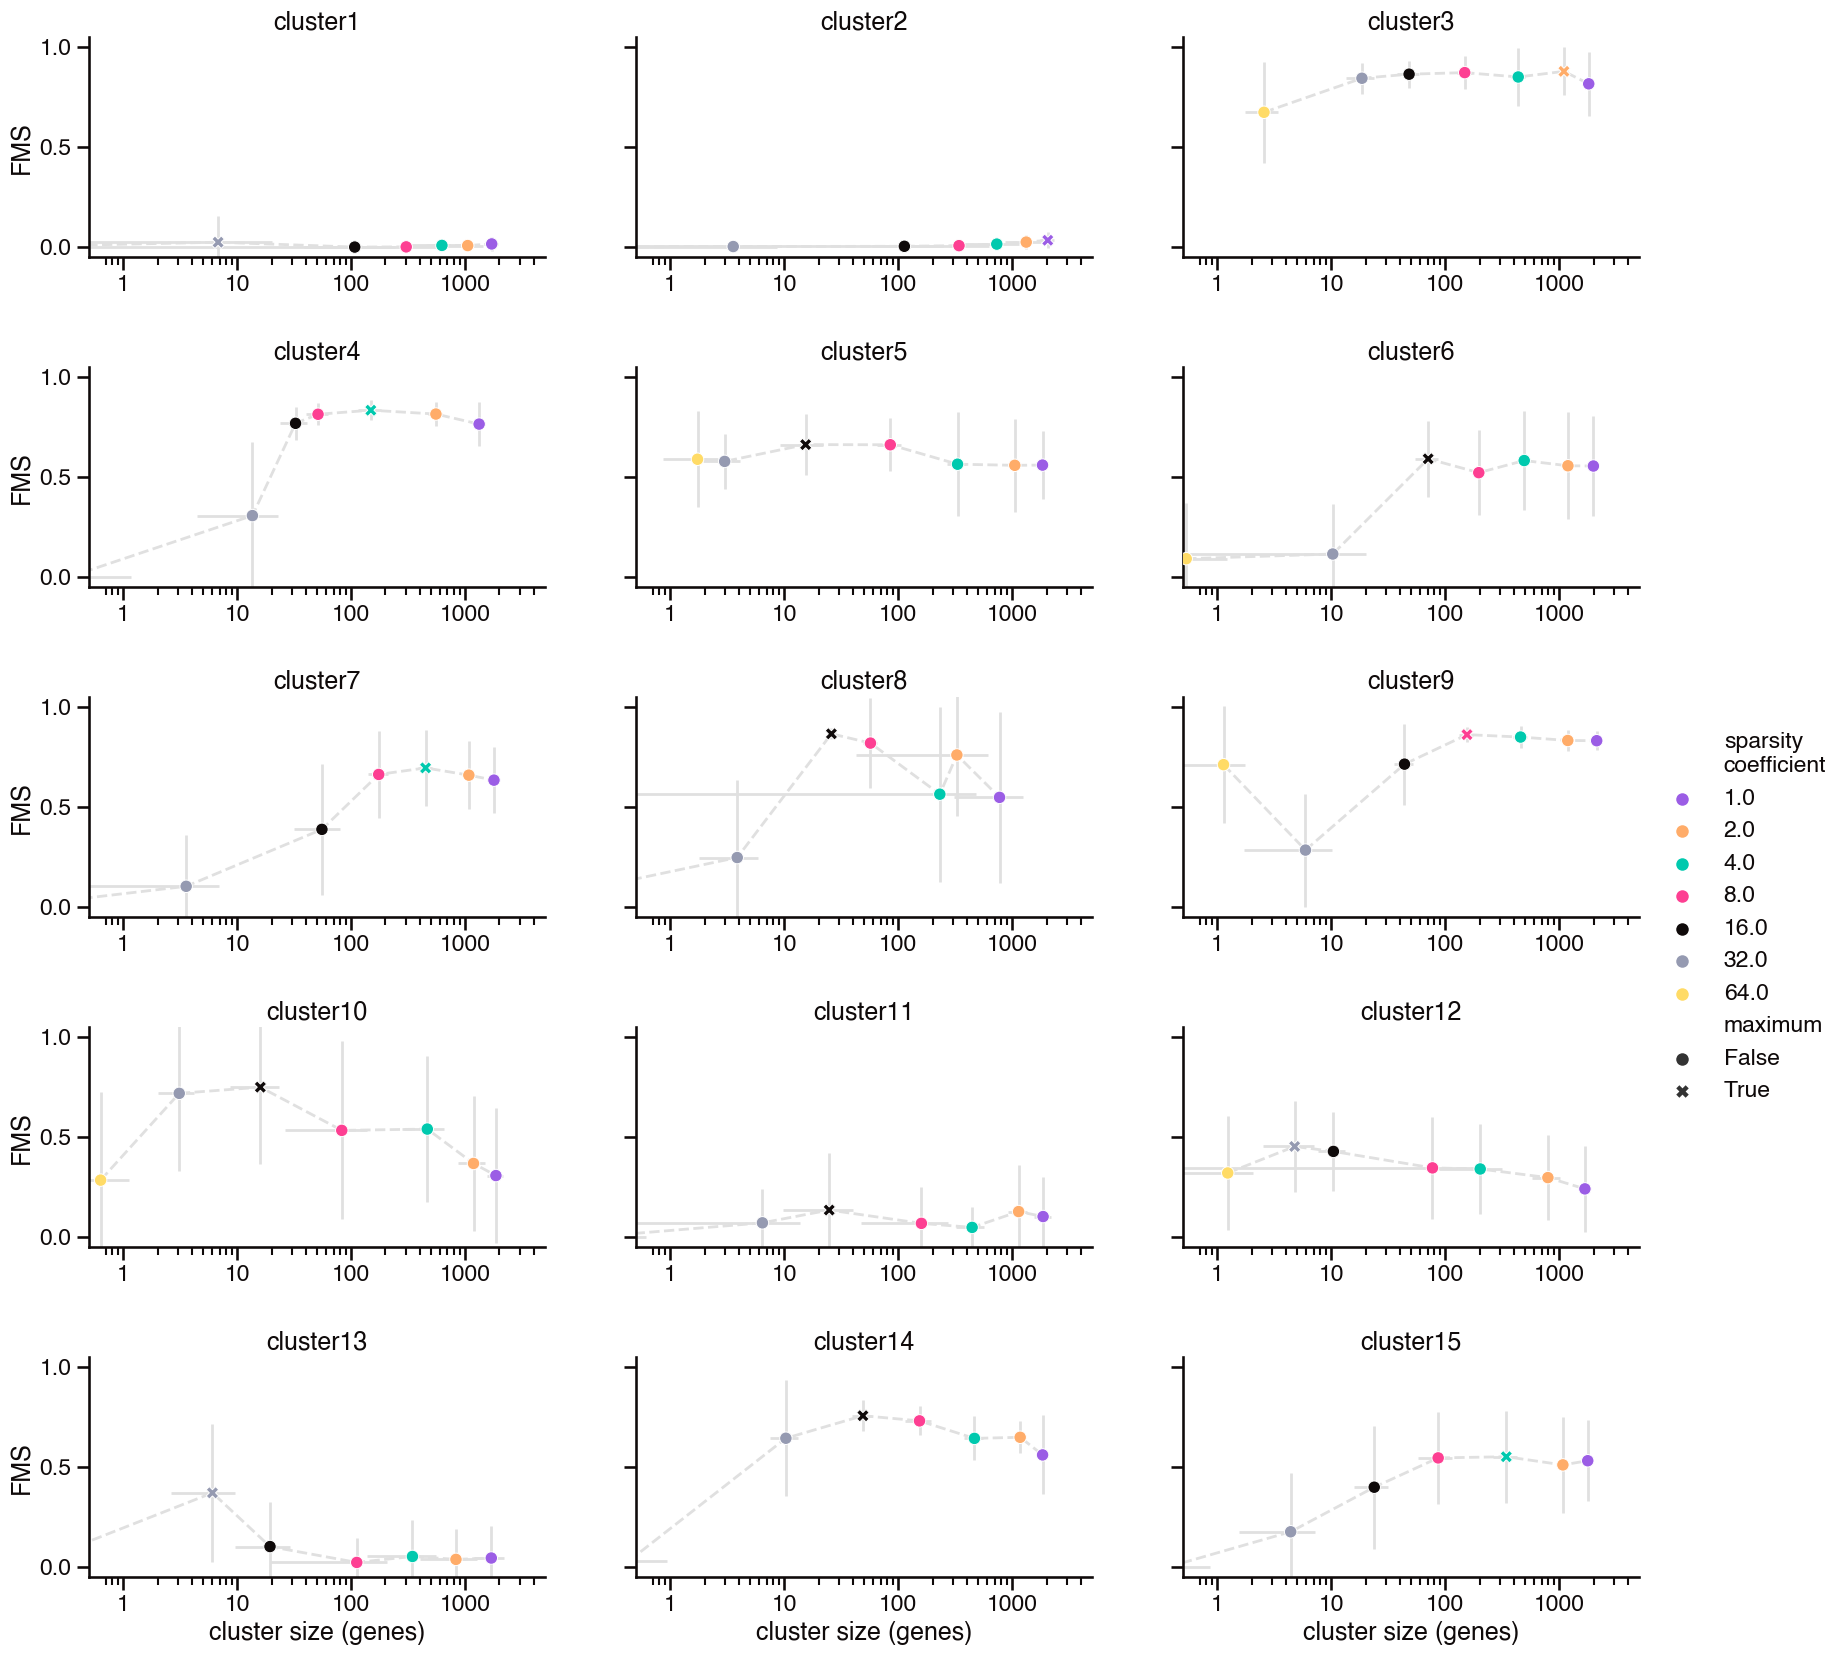

In [18]:
# plot each component FMS profile for Synechococcus

genus = 'syn'
rows = 5
cols = 3

# set up lambda colormap
cmap = dict(zip(lambdas[genus]['comp'], accent_colors))

# set up figure
plt.rcParams['axes.spines.left'] = True
plt.rcParams['axes.spines.bottom'] = True
fig, axes = plt.subplots(
    rows, cols, figsize=(20, 20), sharex=False, sharey=True, gridspec_kw={'hspace': 0.5, 'wspace': 0.2}
)

# plot each component
for component in np.arange(15):
    row = component // cols
    col = component % cols
    axis = axes[row][col]
    plot_df = cv_comp_fms_df[cv_comp_fms_df['genus'] == genus]
    plot_df = plot_df[plot_df['component'] == component]
    plot_df = plot_df.groupby('lambda').agg(
        cluster_size=('ref_gene_cluster_size', 'mean'), 
        cluster_size_err=('ref_gene_cluster_size', 'std'), 
        fms=('fms', 'mean'), 
        fms_err=('fms', 'std'), 
    ).reset_index()
    plot_df['maximum'] = (plot_df['fms'] == plot_df['fms'].max())
    plot_df['sparsity\ncoefficient'] = ['{}'.format(l) for l in plot_df['lambda']]
    sns.lineplot(
        data=plot_df, 
        x='cluster_size', 
        y='fms', 
        errorbar=None, 
        color=neutral_color, 
        linestyle='--', 
        ax=axis, 
        legend=False
    )
    sns.scatterplot(
        data=plot_df, 
        x='cluster_size', 
        y='fms', 
        hue='sparsity\ncoefficient', 
        style='maximum', 
        zorder=3, 
        ax=axis, 
        legend=((row == 2) & (col == (cols - 1)))
    )
    # set legend location
    if ((row == 2) & (col == (cols - 1))):
        axis.legend(loc='center left', bbox_to_anchor=[1, 0])
    # add errorbars
    axis.errorbar(
        data=plot_df, 
        x='cluster_size', 
        y='fms', 
        xerr='cluster_size_err', 
        yerr='fms_err', 
        fmt='none', 
        ecolor=neutral_color
    )
    # set labels and such
    if row == (rows - 1):
        xlabel = 'cluster size (genes)'
    else:
        xlabel = ''
    if col == 0:
        ylabel = 'FMS'
    else:
        ylabel = ''
    axis.set(
        xlim=[0.5, 5000], ylim=[-0.05, 1.05], xscale='log', xlabel=xlabel, ylabel=ylabel, 
        title='cluster{}'.format(component+1)
    )
    axis.set_xticks([1, 10, 100, 1000])
    axis.set_xticks([.7, .8, .9, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 
                     200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000, 4000], minor=True)
    formatter = mpl.ticker.ScalarFormatter()
    formatter.set_scientific(False)
    axis.xaxis.set_major_formatter(formatter)
    
fig.savefig(outdir / '{}_cluster_fms_v_size.png'.format(genus), bbox_inches='tight')
    